# Reto - Creando un agente RAG

En este taller buscaremos desarrollar un agente RAG que sea capaz de respoder preguntas sencillas de manera precisa, empleando como base de conocimiento el texto extraído de distintos enlaces web y los documentos que decidamos compartir.






```
# This is formatted as code
```

## CONFIGURACIÓN DE UN LLM

El LLM que emplearemos para generar las respuestas de nuestro RAG será **Gemini-2.0-Pro**.

Para conseguir una clave de acceso para utilizar los modelos gratuitos de Gemini, tendremos que acceder a [Google AI Studio](https://aistudio.google.com/app/apikey?hl=es-419). Una vez aquí, bastará con iniciar sesión con nuestra cuenta de Google y posteriormente pulsar en "Crear clave de API". Tras seleccionar un proyecto cualquiera y pulsar en "Crear clave de API en un proyecto existente", obtendremos la clave API que deberemos copiar.

⚠️ Es **importante** que copiemos el valor que nos aparecerá en pantalla ya que, al cerrar esa pantalla, no volveremeos a tener acceso a él (sería necesario volver a crear una clave nueva).

Esta clave de API la guardaremos en la sección de *Secretos* de Google Collab. Para ello, basta pulsar el icono "🔑" que aparece en el lateral izquierdo de nuestro notebook de Google Colab, y pulsar en ***Añadir secreto nuevo***. Una vez aquí, colocamos **Nombre: GOOGLE_API_KEY**, y para el **Valor**, la clave que habíamos copiado para nuestro token.



Una vez obtenida la clave de API, configuramos el LLM

In [4]:
pip install -qU google-generativeai

In [3]:
import google.generativeai as genai
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

generation_config = {
    "temperature": 0.1,
    "top_p": 0.9,
    "top_k": 64,
    "max_output_tokens": 10000,
    "response_mime_type": "text/plain",
  }

llm = genai.GenerativeModel(
      model_name="gemini-2.0-flash",
      generation_config=generation_config,
  )


## Configurando el Generador de Embeddings

Para ello será necesario que generemos un token de Hugging Face.

Si aún no tienes una cuenta, puedes registrarte en [Hugging Face](https://huggingface.co/). Solo necesitas proporcionar un correo electrónico, una contraseña y activar tu cuenta a través del correo de verificación que recibirás.  


Una vez registrados, debemos de seguir estos pasos para generar un token:
1. Accede a tu perfil en Hugging Face.  
2. Ve a la sección de **Access Tokens**.  
3. Haz clic en **Create new token**.  
4. Selecciona el nivel de acceso **Read**.  
5. Asigna un nombre a tu token.  
6. Genera el token.  




Una vez creado el token, es **importante** que copiemos el valor que nos aparecerá en pantalla. Al igual que sucedía en el caso de la clave API para Gemini, tras cerrar esa pantalla no podremos volver a acceder a él (sería necesario volver a crear un token nuevo).


Este valor de token lo guardaremos en la sección de *Secretos* de Google Collab. Para ello, tal y como hicimos anteriormente, basta pulsar el icono "🔑" que aparece en el lateral izquierdo de nuestro notebook de Google Collab, y pulsar en ***Añadir secreto nuevo***. Una vez aquí, colocamos **Nombre: HF_TOKEN**, y para el **Valor**, la clave que habíamos copiado para nuestro token.

Una vez ya creado el token y almacenado en los secretos de Google Colab, configuramos el Generador de Embeddings

In [5]:
pip install -qU langchain-huggingface

In [6]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Configurando la colección

Instalamos las dependencias necesarias y definimos nuestra colección o *Vector Store*. Para ello empleamos:
- El Generador de Embeddings que acabamos de configurar.
- RecursiveCharacterTextSplitter para realizar el *chunking*.
- El enlace web "[https://lilianweng.github.io/posts/2023-06-23-agent/](https://lilianweng.github.io/posts/2023-06-23-agent/)" como base de conocmiento

In [7]:
pip install -qU langchain-core langchain-text-splitters langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.6/449.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [8]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [9]:
# Install package
!pip install --upgrade --quiet llmsherpa

In [10]:
pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.5/323.5 kB 5.9 MB/s eta 0:00:00


# Configurando la colección offline

Para que nuestro RAG pueda "leer" documentos offline será necesario añadir la siguiente línea de comando, de forma que pueda almacenar los archivos PDF en un repositorio de Google.

In [16]:
# PARA DOCUMENTOS OFFLINE
from google.colab import files

uploaded = files.upload()

Saving S1TDRC.pdf to S1TDRC.pdf


In [18]:
import pypdf
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# PARA DOCUMENTOS OFFLINE
loader = PyPDFLoader(
    file_path="S1TDRC.pdf")

# PARA DOCUMENTOS ONLINE
# loader = PyPDFLoader(
#     file_path="https://arxiv.org/pdf/2402.14207.pdf"
# )

# PARA VARIOS DOCUMENTOS OFFLINE
# pdf_files = ["EjercicioT1_Protocolos2025.pdf"]

# docs = []
# for pdf_file in pdf_files:
#     loader = PyPDFLoader(pdf_file)
#     docs.extend(loader.load())

# PARA VARIOS DOCUMENTOS ONLINE
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

## Definiendo nuestro agente RAG

Para definir nuestro agente RAG emplearemos LangGraph.
A continuación, se instalan las dependencias necesarias y se define el prompt que se usará para la generación de texto.

In [19]:
pip install -qU langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 15.1 MB/s eta 0:00:00


In [20]:
rag_prompt = """You are an assistant for question-answering tasks. You have to give an answer based on the following context, make the answers as complete as you can and answer them as if you were not the person asked the question, always give a response in spanish"
Question: {question}
Context: {context}
Answer:"""

Una vez hecho esto, en el siguiente código se define el flujo del agente RAG. En particular, en el código a continuación observaremos:
1. **Definición del estado**: Se establece una estructura de datos (`State`) para almacenar la pregunta, el contexto recuperado y la respuesta generada.  
2. **Recuperación de documentos**: Se busca información relevante en la colección a partir de la pregunta del usuario.  
3. **Generación de respuesta**: Se construye un prompt con el contexto recuperado y se envía al modelo de lenguaje para obtener la respuesta.  
4. **Construcción del grafo**: Se utiliza `StateGraph` para encadenar los pasos de recuperación y generación, creando el flujo de procesamiento del agente.  


In [21]:
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph, END
from typing_extensions import List, TypedDict
import numpy as np

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# CALCULA LA SIMILITUD

# def Similarity(state: State):
#     vector_question = embeddings.embed_query(state["question"])
#     # vector_question = numpy.cos(vector_question)
#     # vector_context = embeddings.embed_query(state["context"])
#     vector_context = [embeddings.embed_query(doc.page_content) for doc in state["context"]]
#     # vector_context = numpy.cos(vector_context)
#     # Similarity = numpy.absolute(vector_question - vector_context)
#     vector_context_mean = np.mean(vector_context, axis=0)
#     Similarity = np.dot(vector_question, vector_context_mean) / (np.linalg.norm(vector_question) * np.linalg.norm(vector_context_mean))
#     return {"similarity": Similarity}

# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"]) # te da el contexto
    # print(f"Retrieved docs: {retrieved_docs} \n")
    return {"context": retrieved_docs}

# EVALUA LA SIMILITUD

# def evaluate(state: State):
#      similarity = Similarity(state)
#      similarity = similarity["similarity"]

#      if similarity < 0.1:
#          return {"next_step":END}
#      if 0.1 <= similarity < 0.8:
#          return{"next_step":"retrieve"}
#      else:
#          return{"next_step":"generate"}


def generate(state: State): # generación
    global rag_prompt

    docs_content = "\n\n".join(doc.page_content for doc in state["context"]) # unimos los documentos para insertar los prompts
    prompt = rag_prompt
    prompt = prompt.replace("{question}", state["question"]) # reemplazamos pregunta por la que hemos hecho
    prompt = prompt.replace("{context}", docs_content) # reemplazamos por el contexto

    # Pass prompt to the model
    response = llm.generate_content(prompt) # generamos la respuesta con el LLM
    return {"answer": response.text}

# PARTE PARA QUE FUNCIONE CON LOS NODOS SIMPLES

graph_builder = StateGraph(State).add_edge(START,"retrieve")
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_node("generate", generate)
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()
# # Compile application and test
#  ESTO ES PARA QUE HAGA LA COMPROBACIÓN
# graph_builder = StateGraph(State).add_edge(START, "retrieve")
# graph_builder.add_node("retrieve", retrieve)

# graph_builder.add_edge("retrieve", "evaluate")
# graph_builder.add_node("evaluate", evaluate)
# graph_builder.add_node("generate", generate)

# graph_builder.add_edge("evaluate", "retrieve")
# graph_builder.add_edge("evaluate", "generate")
# graph_builder.add_edge("retrieve", END)

# graph = graph_builder.compile()


Una vez compilado el grafo, ya podemos realizar consultas a nuestro agente RAG:

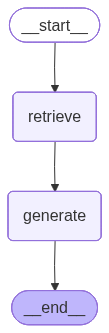

In [22]:
from IPython.display import Image, display
png = graph.get_graph().draw_mermaid_png()
display(Image(png))

In [23]:
response = graph.invoke({"question": "Buenos días, saluda a nuestros lectores!"}, {"recursion_limit": 100})
print(response["answer"])



¡Buenos días a todos nuestros lectores! Es un placer saludarles y compartir información valiosa con ustedes hoy.
